# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация

### Общая информация
Дата выдачи: 16.11.2024

Мягкий дедлайн: 28.11.2024

Жесткий дедлайн: 02.12.2024

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели

----

#### Самостоятельная оценка результатов

Для удобства проверки, исходя из набора решенных задач, посчитайте свою максимальную оценку.

**Оценка**:

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи

Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-linclass-__Username__.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-linclass-__IvanovIvan__.ipynb).

# Часть 1. SVM, LR и калибровка вероятностей (2 балла + 0.5 бонус)

In [1]:
import numpy as np
import pandas as pd
# import polars as pl
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
# pl.Config().set_tbl_rows(100)
# pl.Config().set_tbl_cols(100)


import warnings
warnings.filterwarnings('ignore')

#### __Задание 1.1  Сравнение методов__ (0.5 балла)



Сгенерируем синтетические данные.

In [2]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

__Случайный классификатор__

Для начала зададим самую простую модель, которая на каждом объекте выдаёт случайный ответ. По тестовой выборке вычислим AUC-ROC, AUC-PR.

In [3]:
from sklearn.dummy import DummyClassifier
random_classifier = DummyClassifier(strategy='uniform', random_state=42).fit(X_train, y_train)
y_random = random_classifier.predict_proba(X_test)[:,1]
y_random

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

**Вопрос:** решаем задачу бинарной классификации, но y\_random содержит какие-то дробные числа, а не 0/1. Почему?



**Ответ**: метод predict_proba возвращает вероятности принадлежности к положительному классу

*Ниже приведен **пример** работы* со встроенными функциями `sklearn` для отрисовки ROC и PR кривых, сохранения метрик. Пайплайн можно изменять как вам удобно.

In [4]:
from sklearn.metrics import average_precision_score

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

Random Classifier metrics
AUC-PR: 0.5057
AUC-ROC: 0.5000


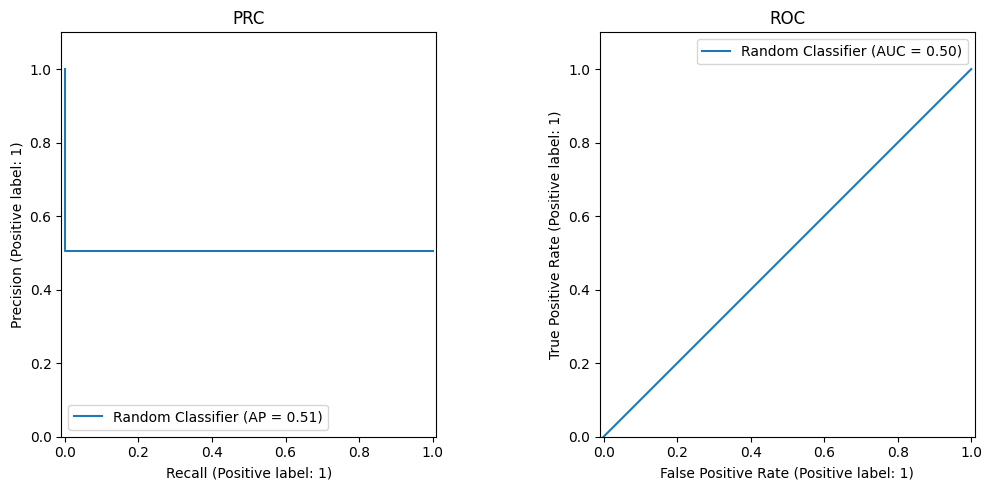

In [5]:
def depict_pr_roc(y_true, y_pred, classifier_name='Some Classifier', ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 2, figsize=(11, 5))

    print(classifier_name, 'metrics')
    PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax[0], name=classifier_name)
    print('AUC-PR: %.4f' % average_precision_score(y_true, y_pred))
    ax[0].set_title("PRC")
    ax[0].set_ylim(0, 1.1)

    RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax[1], name=classifier_name)
    print('AUC-ROC: %.4f' % roc_auc_score(y_true, y_pred))
    ax[1].set_title("ROC")
    ax[1].set_ylim(0, 1.1)

    plt.tight_layout()
    plt.legend()


depict_pr_roc(y_test, y_random, 'Random Classifier')

In [6]:
# dataframe для сравнения
# методов классификации по метрикам
df_metrics = pd.DataFrame(
    columns=['auc_pr', 'roc_auc_score', 'reg_const']
)
precision, recall, _ = precision_recall_curve(y_test, y_random)
# добавление очередной строки с характеристиками метода
df_metrics.loc['Random Classifier'] = [
      average_precision_score(y_test, y_random),
      roc_auc_score(y_test, y_random),
      0,
]

# по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,auc_pr,roc_auc_score,reg_const
Random Classifier,0.505667,0.5,0.0


__Support Vector Machine (Linear Kernel)__

Обучите метод опорных векторов.

Подберите параметр регуляризации `C` с точки зрения AUC-PR (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей).


In [7]:
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import GridSearchCV
gs = GridSearchCV(estimator = LinearSVC(),
                   param_grid = {'C': np.logspace(-3,3,10)},
                   scoring = 'roc_auc',
                   cv = 5)
gs.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LinearSVC(),
             param_grid={'C': array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03])},
             scoring='roc_auc')

In [8]:
print("Лучшее значение параметра C:", gs.best_params_)
print("Лучший AUC-PR на кросс-валидации:", gs.best_score_)

Лучшее значение параметра C: {'C': 0.021544346900318832}
Лучший AUC-PR на кросс-валидации: 0.8506475045243935


  На тестовой части:
  - постройте ROC и PR кривые,
  - посчитайте AUC-ROC, AUC-PR

Some Classifier metrics
AUC-PR: 0.8299
AUC-ROC: 0.8476


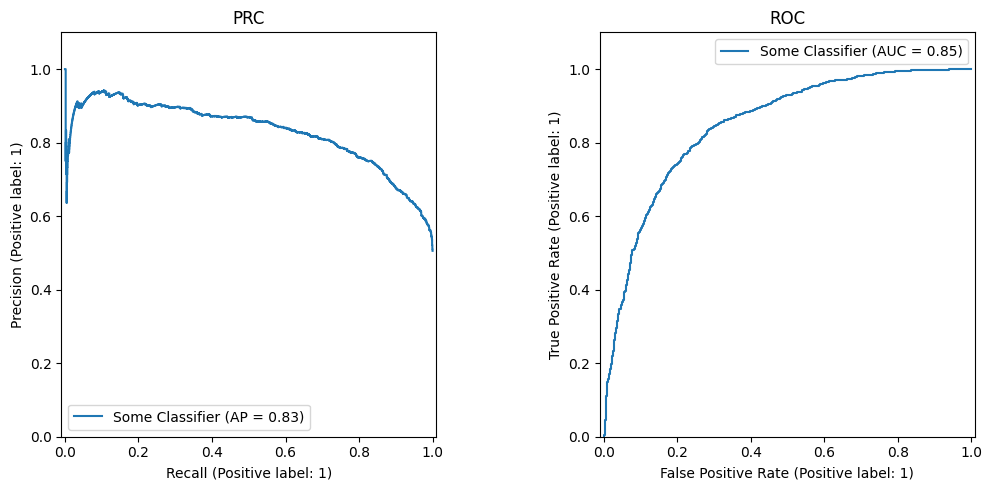

In [9]:
y_pred = gs.best_estimator_.decision_function(X_test)
depict_pr_roc(y_test, y_pred)

Проанализируйте, как себя ведут обе кривые:
- Что происходит при увеличении порога? Как бы вы это проинтерпретировали?
- Монотонные ли кривые? Как вы это объясните?

При увеличении порога сдвигаем значние достаточной вероятности, для перевода в положительный класс

Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора.

In [10]:
df_metrics.loc['Linear_SVC'] = [average_precision_score(y_test, y_pred), roc_auc_score(y_test, y_pred), gs.best_params_['C']]
df_metrics.head(3)

,auc_pr,roc_auc_score,reg_const
Random Classifier,0.505667,0.500000,0.000000
Linear_SVC,0.829903,0.847642,0.021544


__Logistic Regression__


Аналогичное задание для логистической регрессии с L2 регуляризатором:


*   подберите гиперпараметр C, используя метрику AUC-PR
*   нарисуйте ROC, PR кривые для тестовой части
*   выведите метрики для тестовых данных и сравните их с результатами случайного классификатора



In [11]:
from sklearn.linear_model import LogisticRegression

gs_log = GridSearchCV(estimator = LogisticRegression(),
                      param_grid = {'C': np.logspace(-3, 3, 10)},
                      scoring = 'roc_auc',
                      cv = 5)
gs_log.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03])},
             scoring='roc_auc')

In [12]:
print("Лучшее значение параметра C:", gs_log.best_params_)
print("Лучший AUC-PR на кросс-валидации:", gs_log.best_score_)

Лучшее значение параметра C: {'C': 10.0}
Лучший AUC-PR на кросс-валидации: 0.8506968953317303


Some Classifier metrics
AUC-PR: 0.8294
AUC-ROC: 0.8479


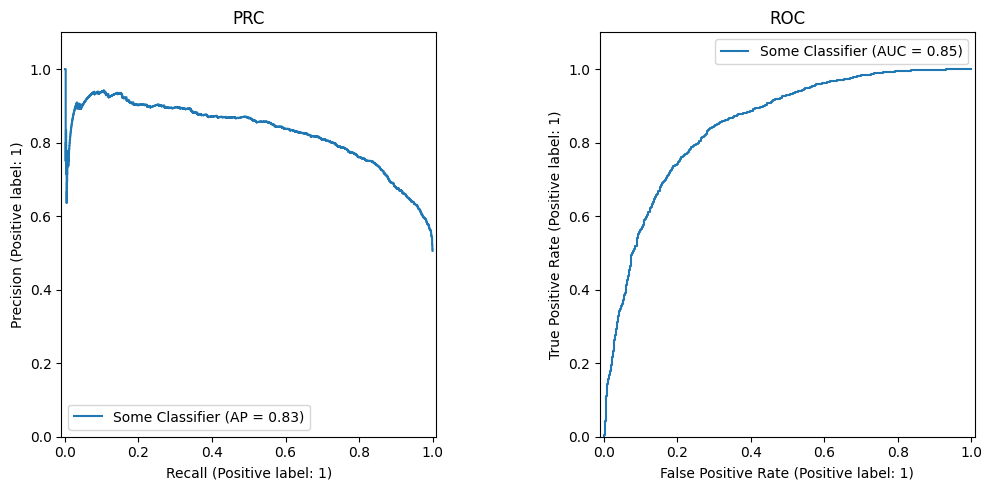

In [13]:
y_pred_log = gs_log.predict_proba(X_test)[:,1]
depict_pr_roc(y_test, y_pred_log)

Нарисуйте ROC, PR кривые для тестовой части для всех 3 классификаторов на одном графике

In [14]:
df_metrics.loc['LR'] = [average_precision_score(y_test, y_pred_log), roc_auc_score(y_test, y_pred_log), gs_log.best_params_['C']]
df_metrics.head(3)

,auc_pr,roc_auc_score,reg_const
Random Classifier,0.505667,0.500000,0.000000
Linear_SVC,0.829903,0.847642,0.021544
LR,0.829384,0.847875,10.000000


**Вопрос:** Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).



**Ответ:** с регуляризацией свм и логистическая регрессия показали одинаковые до тысячных результаты auc_pr и roc_auc_score, можно сказать, что работают почти одинаково.

#### __Задание 1.2. Визуализация в подходах SVM, LR__ (0.5 балла)



В названии метода опорных векторов присутствуют некоторые "опорные векторы". По сути, это объекты из обучающей выборки, которые задали положение разделяющей гиперплоскости.

* Сгенерируйте синтетические данные с помощью `make_classification` __с 2 признаками__, обучите на нём метод опорных векторов. Не забудьте зафиксировать seed для воспроизводимости

* Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы. Ниже есть шаблоны, можете воспользоваться ими, либо написать своё

In [15]:
X, y = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, random_state=42)
svc_model = SVC(kernel = 'linear').fit(X, y)

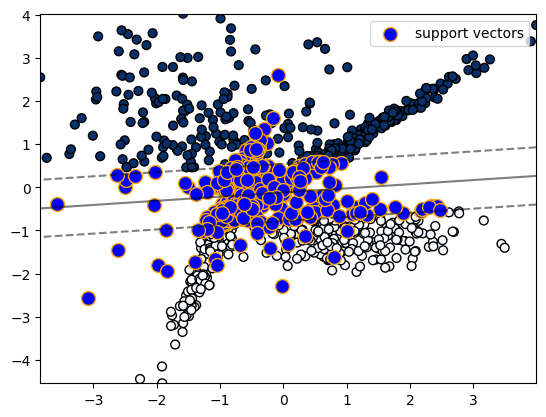

In [16]:
def plot_svm_2D(X, y, model,  plot_support=True):

    # создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 30)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    # Ответы модели для сетки для отрисовки разделяющей прямой
    Z = model.decision_function(xy).reshape(XX.shape)

    plt.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])

    # Отрисовали выборку
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='Blues', s=40, edgecolor='k')

    # Отрисовали опорные векторы
    if plot_support:
      plt.scatter(
          model.support_vectors_[:, 0], model.support_vectors_[:, 1],
          s=100, linewidth=1, edgecolor="orange", facecolors='blue', label='support vectors'
      )

    plt.legend()

plot_svm_2D(X, y, svc_model)

**Вопрос:** какие объекты выделяются как "опорные"?



**Ответ:** на  графике опорные объекты выделены синими кружками с оранжевым контуром. Они лежат ближе всего к разделяющей прямой и определяют оптимальное разделение классов.


В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты.

In [17]:
log_model = LogisticRegression().fit(X,y)

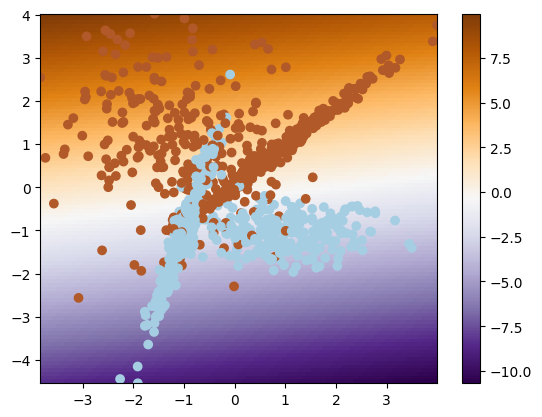

In [18]:
def plot_logreg_2D(X, y, model):

    # создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 100)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 100)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    # Ответы модели для сетки для отрисовки распределения
    Z = model.decision_function(xy).reshape(XX.shape)
    Z = Z.reshape((xx.shape[0], -1)).T

    image = plt.imshow(
        Z,
        interpolation='nearest',
        extent=(xx.min(), xx.max(), yy.min(), yy.max()),
        aspect='auto',
        origin='lower',
        cmap=plt.cm.PuOr_r
    )

    #Отрисовали выборку
    plt.scatter(
        X[:,0], X[:,1], c=y,
        cmap=plt.cm.Paired
    )

    plt.colorbar(image)

plot_logreg_2D(X, y, log_model)

**Вопрос:** Как на картинке визуализирована область, где модель не уверена ($p(y=+1|x) = 0.5$)? Как это обосновать теоритечески?



**Ответ:** В белой зоне на стыке двух цветов модель менее уверена в прогнозах, то есть вероятность принадлежности к каждому классу близка к 0.5, однако, на объектах с большим скалярным проиведением (темно-фиолетовая и тепно-рыжая зоны) прогнозы гораздно устойчивей. Вероятности моделируем через сигмоиду, если скаляр почти равен 0, то вероятность примерно 0.5.

#### __Задание 2. Калибровка вероятностей__ (1 балл)



Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых.

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность?

Хорошо откалиброванный  классификатор должен выдавать значения так, чтобы среди образцов, для которых он дал значение, близкое к $\alpha$, примерно $\alpha * 100 \%$ фактически принадлежали к положительному классу. (Например, если классификатор выдает 0.3 для некоторых, то 30% из них должны принадлежать классу 1)

Для построения калибровочной криовой используем следующий алгоритм:

Разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины.

Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной.

Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [19]:
def plot_calibration_curve(y_test, preds, name, color):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2)
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1))
    plt.figure(figsize=(6,6))
    plt.plot(bin_middle_points, bin_real_ratios, label = name, color = color)
    plt.plot([0, 1], [0, 1], label='Perfect', linestyle='--', color='green')
    plt.ylim([-0.05, 1.05])
    plt.legend()
    plt.grid()

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$).

Отрисуйте калибровочную кривую идеально откалиброванной модели (диагональ)

In [20]:
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

svc_model = LinearSVC().fit(X_train, y_train)
svc_preds = svc_model._predict_proba_lr(X_test)[:, 1]

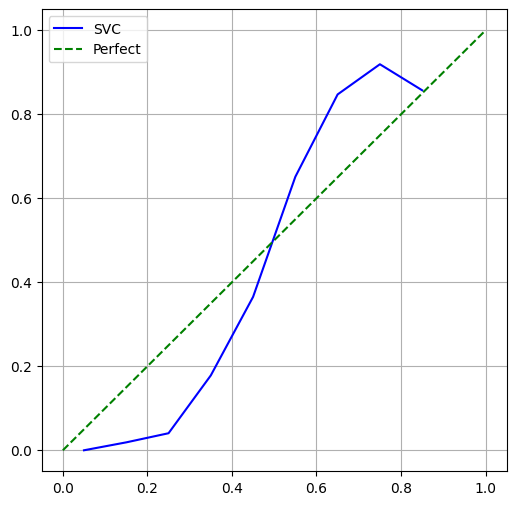

In [21]:
plot_calibration_curve(y_test, svc_preds, 'SVC', 'blue')

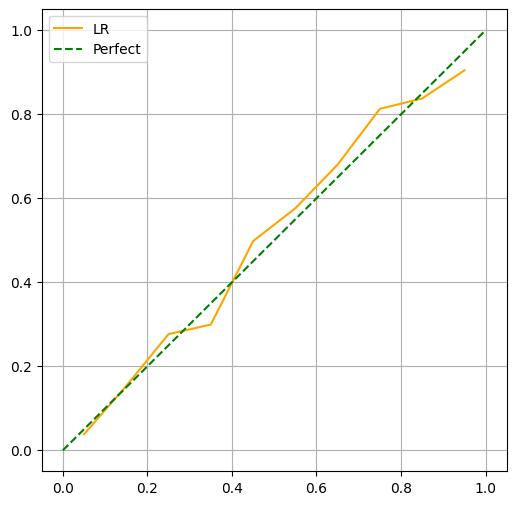

In [22]:
log_reg = LogisticRegression().fit(X_train, y_train).fit(X_train, y_train)
logreg_preds = log_reg.predict_proba(X_test)[:, 1]
plot_calibration_curve(y_test, logreg_preds, 'LR', 'orange')

**Вопрос**: хорошо ли откалиброваны кривые для SVM, логистической регрессии? Подумайте, как это следует из вида кривой

**Ответ:** Кривая для логистической регрессии смотрится весьма прилично: она достаточно близка к диагонали, это означает, что предсказанные вероятности практически совпадают с фактическими вероятностями. Небольшие отклонения есть, но не требуется серьезная корректировка.

Кривая свм выглядит невкусно, модель плохо откалибрована. Предсказанные вероятности не совпадают с фактическими, особенно в средней части вероятностей (0.4–0.8).Например, при предсказании вероятности около 0.6 модель фактически имеет гораздо более высокую уверенность в истинности результата (ближе к 0.8).




Из формальных способов в этом убедиться есть знакомый вам LogLoss, который напрямую оценивает вероятности,
$$\text{LogLoss} = -\frac{1}{N}\sum_{i} \sum_{k \in {0. 1}}\log p_k[y_i = k]$$
а так же BrierScore, который подсчитывает отклонение между получившейся вероятностью и реальным значением таргета.
$$\text{BrierScore} = \frac{1}{N}\sum_{i} (p_i - y_i)^2$$
Посмотрите на них тоже и сделайте вывод

In [23]:
from sklearn.metrics import brier_score_loss, log_loss
print(f'Log-loss SVC: {log_loss(y_test, svc_preds)}')
print(f'Log-loss LR: {log_loss(y_test, logreg_preds)}')

Log-loss SVC: 0.5520712135729844
Log-loss LR: 0.4858556295167715


Логлосс для ЛР в районе 0.48 указывает на то, что вероятности предсказываются значительно лучше, чем у случайной модели. Если модель предсказывает вероятность 0.5 для всех объектов то, ошибка будет около 0.693. Чем больше значени, тем хуже качество вероятностных предсказаний, измеряется от 0 до бесконечности

In [24]:
print(f'Brier score SVC: {brier_score_loss(y_test, svc_preds)}')
print(f'Brier score LR: {brier_score_loss(y_test, logreg_preds)}')

Brier score SVC: 0.18316547688479232
Brier score LR: 0.15858348672613165


Хорошее качество: Значение для ЛР 0.158 меньше, чем 0.25, что указывает на то, что модель лучше, чем случайное угадывание. Результат удовлетворительный, но можно и лучше(((

Изучите распределение ответов классификаторов при помощи гистограмм

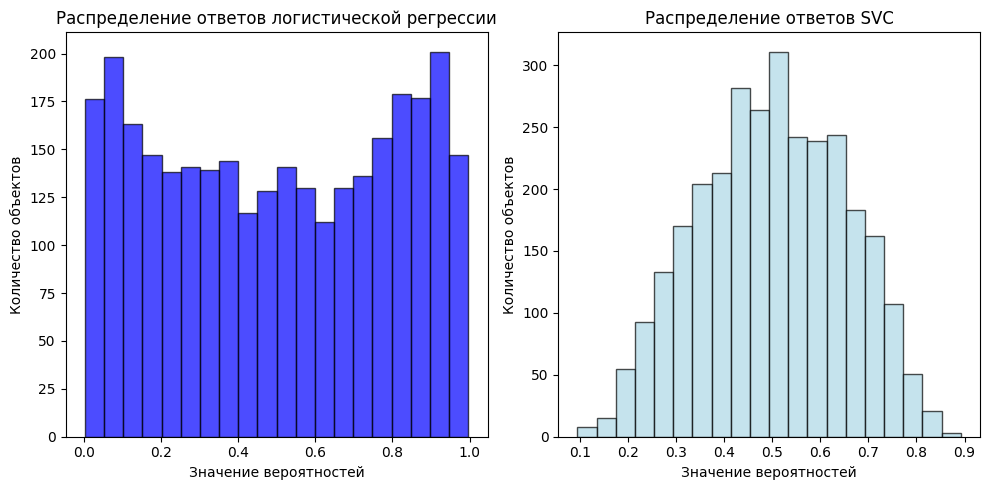

In [25]:
import matplotlib.pyplot as plt

# Создание фигуры
plt.figure(figsize=(10, 5))

# Гистограмма для логистической регрессии
plt.subplot(121)  # Используем упрощённый способ для индексации подграфиков
plt.hist(logreg_preds, bins=20, color='blue', alpha=0.7, edgecolor='black')
plt.title('Распределение ответов логистической регрессии')
plt.xlabel('Значение вероятностей')
plt.ylabel('Количество объектов')

# Гистограмма для SVC
plt.subplot(122)
plt.hist(svc_preds, bins=20, color='lightblue', alpha=0.7, edgecolor='black')
plt.title('Распределение ответов SVC')
plt.xlabel('Значение вероятностей')
plt.ylabel('Количество объектов')

# Корректировка расположения графиков
plt.tight_layout()

**Вопрос:** Чем они различаются? Чем вы можете объяснить это?

**Ответ:** логистическая регрессия (слева): распределение имеет два пика на краях (около 0 и 1) и менее выраженные вероятности в средней части (0.4–0.6), похоже модель склонна предсказывать вероятности, которые близки к крайним значениям, и редко остаётся неуверенной. Функция логистической регресии лучше лучше определяет вероятности.

свм (справа) хуже калибрована, это приводит к тому, что модель чаще предсказывает 0.5 вероятности, даже для данных, которые могли бы быть классифицированы с большей уверенностью, распределение имеет нормальную форму с пиком около 0.5.

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью  предсказания для тестовой выборки.

In [26]:
X_train_val, X_val, y_train_val, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=777, stratify = y_train)

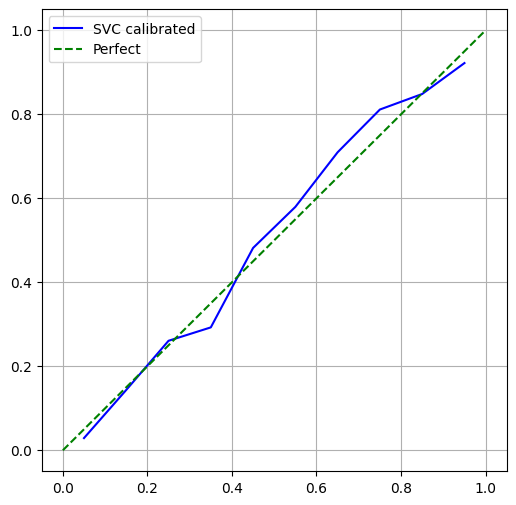

In [27]:
from sklearn.calibration import CalibratedClassifierCV
my_cccv = CalibratedClassifierCV(svc_model, cv = 'prefit')
my_cccv.fit(X_val, y_val)
y_pred_calibr = my_cccv.predict_proba(X_test)[:, 1]
plot_calibration_curve(y_test, y_pred_calibr, 'SVC calibrated', 'blue')

**Вопрос:** Улучшились ли калибровочная кривая и качество калибровки?

**Ответ:** ДА, опреденно стало лучше. После калибровки модель начала предсказывать вероятности, которые больше похожи на фактические.

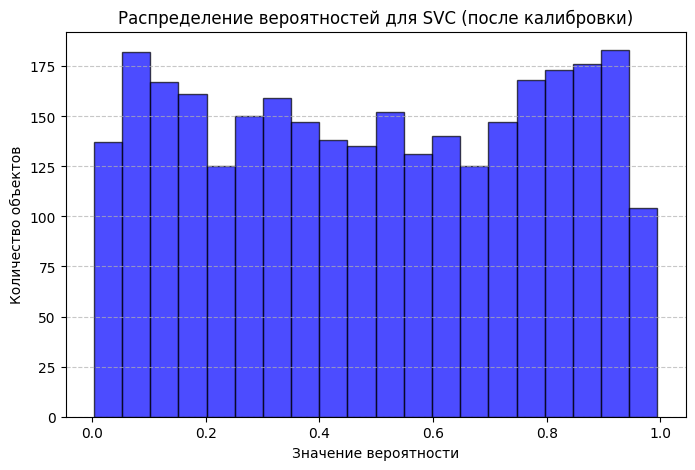

In [28]:
plt.figure(figsize=(8, 5))
plt.hist(y_pred_calibr, bins=20, color='blue', alpha=0.7, edgecolor='black')
plt.title('Распределение вероятностей для SVC (после калибровки)')
plt.xlabel('Значение вероятности')
plt.ylabel('Количество объектов')
plt.grid(axis='y', linestyle='--', alpha=0.7)

Распределение очень равномерное, теперь матожидание не равно 0.5, теперь выдаем более конкретные прогнозы.

##### __Бонус: Авторское решение__ (0.5 балла)

Реализуйте свою функцию для калибровки вероятностей, используя любой из известных подходов. Кратко опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

In [29]:
# your code here

# Часть 2. Обработка категориальных переменных (4 балла + 1.5 бонус)

Как мы знаем, перекодировать категориальную переменную в список чисел (к примеру 1, 2, 3, ..., n) плохо, поскольку это бы задало на множестве ее значений некоторый порядок, не имеющий смысла.

В этой части мы рассмотрим два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

#### __Подготовка данных__

*(бесценный шаг)*

Разберем датасет [покупок велосипедов](https://www.kaggle.com/datasets/heeraldedhia/bike-buyers/): даны признаки покупателя, требуется предсказать, купит ли он/она велосипед



Замените пропуски в категориальных переменных на новую категорию (`'undefined'`)

Разделите признаки на 2 таблицы: категориальные и числовые признаки

In [30]:
import kagglehub

path = kagglehub.dataset_download("heeraldedhia/bike-buyers") +  "/bike_buyers.csv"

In [31]:
df = pd.read_csv(path)
# Заменим пропуски категориальных переменных
df.update(df.select_dtypes(include='object').fillna('undefined'))
X, y = df.iloc[:,:-1], df.iloc[:,-1] == 'Yes'

# # Разделим на категориальные признаки и числовые
X_numerical = X.select_dtypes(exclude = 'object')
X_categorical = X.select_dtypes(include = 'object')

В начале поработаем только с категориальными признаками

In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_categorical, y, test_size=0.25, random_state=777, stratify=y)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 750 entries, 345 to 883
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Marital Status    750 non-null    object
 1   Gender            750 non-null    object
 2   Education         750 non-null    object
 3   Occupation        750 non-null    object
 4   Home Owner        750 non-null    object
 5   Commute Distance  750 non-null    object
 6   Region            750 non-null    object
dtypes: object(7)
memory usage: 46.9+ KB


#### __Задание 3. OrdinalEncoder__  (0.5 балла)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c __`AUC-PR`__) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели, с учетом кодирования признаков.

In [33]:
%%time
import time
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder

pipe_ord = Pipeline([('encoder', OrdinalEncoder()), ('LR', LogisticRegression())])
y_pred_ord = pipe_ord.fit(X_train, y_train).predict_proba(X_test)[:,1]
print("AUC-PR OrdinalEncoder на тесте", average_precision_score(y_test, y_pred_ord))

AUC-PR OrdinalEncoder на тесте 0.5886533539773633
CPU times: user 30.1 ms, sys: 932 µs, total: 31 ms
Wall time: 44.9 ms


#### __Задание 4. One-Hot Encoding__ (0.5 балла)



Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (в сравнении с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.

In [34]:
%%time
from sklearn.preprocessing import OneHotEncoder
pipe_ohe = Pipeline([('encoder', OneHotEncoder()), ('LR', LogisticRegression())])
y_pred_ohe = pipe_ohe.fit(X_train, y_train).predict_proba(X_test)[:,1]
print("AUC-PR OHE на тесте", average_precision_score(y_test, y_pred_ohe))

AUC-PR OHE на тесте 0.6662544177340515
CPU times: user 32.8 ms, sys: 844 µs, total: 33.7 ms
Wall time: 38.3 ms


Как можно заметить, one-hot-кодирование может сильно увеличивать количество признаков. Это сказывается на объеме необходимой памяти, особенно, если некоторый признак имеет большое количество значений.


#### __Задание 5. Mean-target Encoding__ (1 балл)

> Проблемы разрастания числа признаков можно избежать в другом способе кодирования категориальных признаков — mean-target encoding (для простоты будем называть это __счётчиками__). Сравним эффективность методов в рамках нашей маркетинговой задачи.

> Основная идея в том, что важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:

$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)]}
$$

Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве.

Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков).

In [35]:
def mean_targeting(X_train, y_train, X_test, columns):
  for col in columns:
    mean_values = X_train.join(y_train).groupby(col)[y_train.name].agg(['sum', 'count'])
    mean_values = mean_values['sum']/mean_values['count']
    X_train[col] = X_train[col].map(mean_values)
    X_test[col] = X_test[col].map(mean_values)
  return X_train, X_test

In [36]:
%%time
apply_cols = X_train.columns
X_train_2, X_test_2 = mean_targeting(X_train.copy(), y_train, X_test.copy(), apply_cols.to_list())

mean_target_log = LogisticRegression().fit(X_train_2, y_train)
y_pred_mean_target = mean_target_log.predict_proba(X_test_2)[:,1]

print("AUC-PR Mean Target на тесте", average_precision_score(y_test, y_pred_mean_target))

AUC-PR Mean Target на тесте 0.6575110261581697
CPU times: user 72.6 ms, sys: 759 µs, total: 73.4 ms
Wall time: 177 ms


Пока дольше всех по времени работает, а по качеству уступает охе

##### __Бонус: Эффективная реализация (1 балл)__

Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их.

In [37]:
# ляляля

_______

__Методы борьбы с переобучением счетчиков__


Отметим, что mean-target encoding признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к __переобучению__, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его __целевая метка не использовалась__.

Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки.

#### __Задание 6. Пошумим__  (0.5 балла)

Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям.  При этом постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков. Снова обучите логистическую регрессию, оцените качество.

In [38]:
np.random.seed(42)
def mean_targeting_noise(X_train, y_train, X_test, columns):
  for col in columns:
    mean_values = X_train.join(y_train).groupby(col)[y_train.name].agg(['sum', 'count'])
    mean_values = mean_values['sum']/mean_values['count'] + np.random.normal(0, 0.01, len(mean_values))
    X_train[col] = X_train[col].map(mean_values)
    X_test[col] = X_test[col].map(mean_values)
  return X_train, X_test

In [39]:
%%time
apply_cols = X_train.columns
X_train_2, X_test_2 = mean_targeting_noise(X_train.copy(), y_train, X_test.copy(), apply_cols.to_list())

mean_target_noise = LogisticRegression().fit(X_train_2, y_train)
y_pred_mean_target_noise = mean_target_noise.predict_proba(X_test_2)[:,1]

print("AUC-PR Mean Target на тесте с шумом", average_precision_score(y_test, y_pred_mean_target_noise))

AUC-PR Mean Target на тесте с шумом 0.6655823197837316
CPU times: user 66.9 ms, sys: 480 µs, total: 67.3 ms
Wall time: 78.6 ms


**Вопрос:** Сделайте выводы. Помогло ли добавление шума? Почему?

**Ответ:** Качество варианта с шумом и обычного охе примерно одинаковое, но быстрее работает охе. Возможно стоит оптимизировать функции, сейчас работаем медленно, можно быстрее.

##### __Бонус: другой подход__ (0.5 балла)

Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум).




In [40]:
# your code here

#### __Задание 7. Сглаживание счетчиков__  (1 балл)

> Теперь ответим на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times \text{global_mean}}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$


где $\text{global_mean}$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (можно использовать 10 или подобрать для каждого признака свой). Идея в том, что мы "разбавляем" среднее значение по категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке.

> Вместо среднего значения целевой переменной для сглаживания можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!

Добавьте сглаживание, описанное выше и повторите эксперименты. Подберите $C$, чтобы качество было лучше, чем при использовании One-Hot-Encoding


In [41]:
def mean_targeting_smoothe(X_train, y_train, X_test, columns, c = 10):
  global_mean = y_train.mean()
  for col in columns:
    mean_values = X_train.join(y_train).groupby(col)[y_train.name].agg(['sum', 'count'])
    mean_values = (mean_values['sum']+c*global_mean)/(mean_values['count']+c)
    X_train[col] = X_train[col].map(mean_values)
    X_test[col] = X_test[col].map(mean_values)
  return X_train, X_test

In [42]:
%%time
apply_cols = X_train.columns
X_train_2, X_test_2 = mean_targeting_smoothe(X_train.copy(), y_train, X_test.copy(), apply_cols.to_list())

mean_target_smoothe = LogisticRegression().fit(X_train_2, y_train)
y_pred_mean_target_smoothe = mean_target_smoothe.predict_proba(X_test_2)[:,1]

print("AUC-PR Mean Target на тесте сглаженный", average_precision_score(y_test, y_pred_mean_target_smoothe))

AUC-PR Mean Target на тесте сглаженный 0.671269270765978
CPU times: user 79.4 ms, sys: 6.66 ms, total: 86.1 ms
Wall time: 144 ms


#### **Задание 8. Числовые или категориальные?**  (0.5 балла)

Теперь добавим числовые признаки к счётчикам (тем, которые дали наибольший прирост качества).


Проверьте их на наличие выбросов и заполните пропуски средним или медианой, подумайте, что лучше в условиях наших данных



In [43]:
num_train, num_test, _, _ = train_test_split(X_numerical.drop('ID', axis = 1), y, test_size=0.25, random_state=777, stratify=y)
cat_train, cat_test, y_train, y_test = train_test_split(X_categorical, y, test_size=0.25, random_state=777, stratify=y)
num_train.isnull().sum(), num_test.isnull().sum()

(Income      5
 Children    6
 Cars        7
 Age         5
 dtype: int64,
 Income      1
 Children    2
 Cars        2
 Age         3
 dtype: int64)

<Axes: >

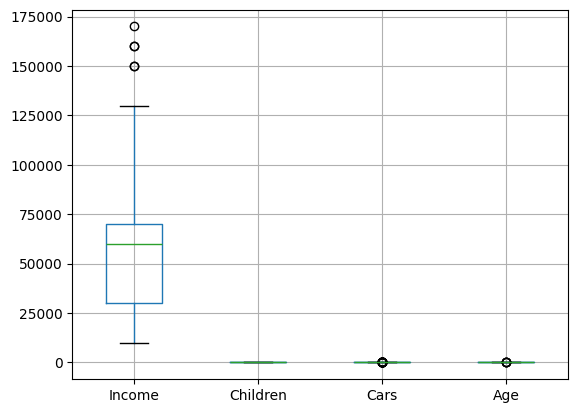

In [44]:
num_train.boxplot()

In [45]:
num_train = (num_train.fillna(num_train.median()))
num_test = (num_test.fillna(num_train.median()))

 Сейчас для числовых признаков мы ищем линейную зависимость, что в общем случае  может быть неверной гипотезой. Тем не менее, у этих признаков есть довольно много уникальных значений (сколько?), поэтому применять к ним one-hot кодирование может оказаться излишним. Попробуйте закодировать эти признаки с помощью счетчиков. Стало ли лучше?

In [46]:
num_train.nunique()
num_test.nunique()

,0
Income,16
Children,6
Cars,5
Age,45


In [47]:
X_train = num_train.join(cat_train)
X_test = num_test.join(cat_test)

In [48]:
def mean_targeting_smoothe(X_train, y_train, X_test, columns, c = 10):
  global_mean = y_train.mean()
  for col in columns:
    mean_values = X_train.join(y_train).groupby(col)[y_train.name].agg(['sum', 'count'])
    mean_values = (mean_values['sum']+c*global_mean)/(mean_values['count']+c)
    X_train[col] = X_train[col].map(mean_values)
    X_test[col] = X_test[col].map(mean_values)
  return X_train, X_test

In [49]:
%%time
apply_cols = X_train.columns
X_train_2, X_test_2 = mean_targeting_smoothe(X_train.copy(), y_train, X_test.copy(), apply_cols.to_list())
mean_target_smoothe = LogisticRegression().fit(X_train_2, y_train)
y_pred_mean_target_smoothe = mean_target_smoothe.predict_proba(X_test_2)[:,1]

print("AUC-PR Mean Target на тесте сглаженный", average_precision_score(y_test, y_pred_mean_target_smoothe))

AUC-PR Mean Target на тесте сглаженный 0.6714401914354916
CPU times: user 107 ms, sys: 0 ns, total: 107 ms
Wall time: 279 ms


> __Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).



Как мы могли пронаблюдать, счётчики являются конкурентной альтернативой one-hot-кодированию. Опишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__

Плюсы:
* Снижение размерности данных: не плодим триллион колонок
* Немного точнее работает чем охе

Минусы:
* Работает дольше чем охе

# Часть 3. Отбор признаков (2 балла)

Загрузим данные [UCI Adult Dataset](https://archive.ics.uci.edu/ml/datasets/Adult). Этот набор данных содержит информацию о годовых доходах отдельных людей. В качестве признакового описания используется различная информация о человеке (образование, профессия, брачный статус и т.д.). Целевая переменная является бинарной: больше ли годовой доход 50K долларов или нет.

In [50]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

--2024-12-02 20:41:31--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘adult.data.2’

adult.data.2            [     <=>            ]   3.79M  3.14MB/s    in 1.2s    

2024-12-02 20:41:33 (3.14 MB/s) - ‘adult.data.2’ saved [3974305]



In [51]:
columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
    'income'
]

df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')
df.sample()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
26858,66,Private,262285,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,99,United-States,0


In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  income          32561 non-null  int32 
dtypes: int32(1), int64(6), object(8)
memory usage: 3.6+ MB


Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.



Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify=True`.

In [53]:
X, y = df.iloc[:,:-1], df.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify = y)
cat_cols = X_train.select_dtypes(include='object')
X_train.shape

(24420, 14)

Давайте закодируем все категориальные признаки с помощью One-hot Encoding. Сколько новых признаков мы получим?

In [54]:
num_cols_train = X_train.select_dtypes(exclude='object')
num_cols_test = X_test.select_dtypes(exclude='object')

ohe = OneHotEncoder(handle_unknown='ignore')
X_train_encoded = pd.DataFrame(ohe.fit_transform(X_train.select_dtypes(include='object')).toarray(), columns=ohe.get_feature_names_out(), index=X_train.index)
X_test_encoded = pd.DataFrame(ohe.transform(X_test.select_dtypes(include='object')).toarray(), columns=ohe.get_feature_names_out(), index=X_test.index)

X_train = X_train_encoded.join(num_cols_train)
X_test = X_test_encoded.join(num_cols_test)

print(X_train.shape)
print(X_test.shape)

(24420, 108)
(8141, 108)


В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [55]:
log_reg = LogisticRegression().fit(X_train, y_train)
y_pred = log_reg.predict_proba(np.array(X_test))[:,1]
print("AUC-PR на тесте", average_precision_score(y_test, y_pred))

AUC-PR на тесте 0.4559973303655656


Допустим, мы хотим оставить только 40 лучших признаков.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, одну из которых, используйте для валидации. Исходную тестовую выборку стоит использовать только для финальной оценки качества после процедуры фильтрации

In [56]:
X_train_val, X_val, y_train_val, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=777, stratify = y_train)
print(X_train_val.shape)
print(X_val.shape)

(19536, 108)
(4884, 108)


Попробуем сделать это следующими способами:

#### __Задание 9. Встроенные методы (0.5 балла)__

Начнём с отбора признаков с помощью модели. У разных алгоритмов есть разные встроенные способы оценки вклада признаков в предсказание. Как известно, у линейной модели за это отвечают веса, а значит, их модуль можно интерпретировать как важность. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.



In [57]:
%%time
idx = (np.argsort(np.abs(log_reg.coef_)))[0][-40:]

X_train_40 = X_train[X_train.columns[idx]]
X_test_40 = X_test[X_test.columns[idx]]
log_reg = LogisticRegression().fit(X_train_40, y_train)

y_pred = log_reg.predict_proba(X_test_40)[:,1]
print("AUC-PR на тесте", average_precision_score(y_test, y_pred))

AUC-PR на тесте 0.678506835068959
CPU times: user 525 ms, sys: 280 ms, total: 805 ms
Wall time: 433 ms


Изменилось ли качество? Как?

Подумаем, что мы не учли. Мы действовали в предположении, что признаки вносят вклад равномерно, и не учитывали их масштаб. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки.

Помните, что не все способы одинаково хороши, особенно в условиях наличия выбросов

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [58]:
X, y = df.iloc[:,:-1], df.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify = y)
cat_cols = X_train.select_dtypes(include='object')
X_train.shape

(24420, 14)

In [59]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

transformer = ColumnTransformer([('ohe', OneHotEncoder(handle_unknown='ignore'), X_train.select_dtypes(include='object').columns),
    ('scaler', StandardScaler(), X_train.select_dtypes(exclude='object').columns)])

pipe = Pipeline([('preprocessor', transformer), ('LR', LogisticRegression())])

pipe.fit(X_train, y_train)
y_pred = pipe.predict_proba(X_test)[:,1]
print("AUC-PR на тесте", average_precision_score(y_test, y_pred))

AUC-PR на тесте 0.7672340764944497


Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [60]:
cat_cols = X_train.select_dtypes(include='object').columns
num_cols = X_train.select_dtypes(exclude='object').columns

cat_pipe = Pipeline([('ohe', OneHotEncoder(handle_unknown='ignore')), ('scaler', StandardScaler(with_mean=False))])
num_pipe = Pipeline([('scaler', StandardScaler(with_mean=False))])

transformer = ColumnTransformer([
    ('categorical', cat_pipe, cat_cols),
    ('numerical', num_pipe, num_cols)])

pipe = Pipeline([
    ('preprocessor', transformer),
    ('model', LogisticRegression())])

pipe.fit(X_train, y_train)
y_pred = pipe.predict_proba(X_test)[:,1]
print("AUC-PR на тесте", average_precision_score(y_test, y_pred))

AUC-PR на тесте 0.7662604270064423


#### __Задание 10. Методы фильтрации (0.5 балла)__


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods.

Одна из самых простых функция - корреляция между признаком и целевой переменной. Подумайте, какая взаимосвязь между корреляцией и предсказательной способностью модели, и как бы вы использовали информацию о корреляции для отбора признаков

**Ответ:** # your code here

Посчитайте корреляцию каждого признака с таргетом и отфильтруйте 40 признаков исходя из того, что вы описали, после чего замерьте качество и время отбора



In [61]:
num_cols_train = X_train.select_dtypes(exclude='object')
num_cols_test = X_test.select_dtypes(exclude='object')

ohe = OneHotEncoder(handle_unknown='ignore')
X_train_encoded = pd.DataFrame(ohe.fit_transform(X_train.select_dtypes(include='object')).toarray(), columns=ohe.get_feature_names_out(), index=X_train.index)
X_test_encoded = pd.DataFrame(ohe.transform(X_test.select_dtypes(include='object')).toarray(), columns=ohe.get_feature_names_out(), index=X_test.index)

X_train = X_train_encoded.join(num_cols_train)
X_test = X_test_encoded.join(num_cols_test)

In [62]:
corr_mask = np.argsort(np.abs(X_train.corrwith(y_train))).values<40

X_train_corr = X_train.iloc[:,corr_mask]
X_test_corr = X_test.iloc[:,corr_mask]
log_reg_corr = LogisticRegression().fit(X_train_corr, y_train)
y_pred = log_reg_corr.predict_proba(X_test_corr)[:,1]
print("AUC-PR на тесте", average_precision_score(y_test, y_pred))

AUC-PR на тесте 0.6255439362180906


В качестве еще одной функция можно считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

Оставьте 40 признаков с наибольшим значением $t$, замерьте качество и скорость отбора признаков.

In [63]:
def count_t(X_train, y_train):
  mask = X_train.join(y_train)[y_train.name]==1
  n_0, n_1 = mask.value_counts()[0], mask.value_counts()[1]
  mu_0 = X_train[mask].mean()
  mu_1 = X_train[~mask].mean()

  sigma_0 = X_train[mask].var()
  sigma_1 = X_train[~mask].var()
  t_stat = np.abs(mu_1-mu_0)/(np.sqrt((n_1*sigma_1*n_0*sigma_0)/n_0+n_1))
  return t_stat

In [64]:
lol = count_t(X_train, y_train).sort_values()[-40:].index
log_reg_t = LogisticRegression().fit(X_train[lol], y_train)
y_pred = log_reg_t.predict_proba(X_test[lol])[:, 1]
print("AUC-PR на тесте", average_precision_score(y_test, y_pred))

AUC-PR на тесте 0.6976155222771501


#### __Задание 11. Методы-обёртки__ (1 балл)

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем признаки по очереди и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества). Более конкретно, алгоритм выглядит так:

- $k$ - число признаков, которых мы хотим оставить
- $m$ - число признаков, которых мы выбрасываем на каждой итерации, оно же длина шага

Шаг $i$:
- $F_i$ - набор признаков (равный всему множеству признаков на i=0)
- $M_i$ - их число, в общем случае $\max(k, M_{i-1} - m)$
1. Если признаков осталось ровно $k$, либо метрика стала уменьшаться более, чем на $\epsilon$ — останавливаемся (не наш случай, но так тоже можно)
2. Обучаем модель $a_i$ на наборе $F_i$, после чего оцениваем важность признаков (любым из способов выше или какими-нибудь ещё)
3. Отбираем $\min(M_i - k, m)$ наиболее бесполезных, согласно пункту 2, признаков (берем $m$, если можем, иначе оставляем вплоть до k), удаляем, переходим к следующему шагу

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Подберите длину шага из каких-то соображений (каких, кстати?) и замерьте время работы метода

In [65]:
# это не сделано, но сделано ниже другое

Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ самые полезные признаки в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [66]:
# это не сделано, но сделано ниже другое

Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:** # your code here

# Часть 4. Оценка экономического эффекта модели (2 балла)



В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно:
- мы соберем несколько специализированных метрик качества,
- попытаемся настроить модель на максимизацию _прибыли_,
- оценим, сколько вообще получится заработать на этом.

Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.


#### __Задание 12. Прогноз по доходам и расходам__ (1 балл)

В этой части мы будем работать с данными [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге.

__Объектом__ здесь является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.
__Целевая переменная__ - ответ клиента (согласился ли он открыть депозит?)

In [67]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
!unzip bank-additional.zip
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

--2024-12-02 20:41:39--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘bank-additional.zip’

bank-additional.zip     [   <=>              ] 434.15K   568KB/s    in 0.8s    

2024-12-02 20:41:43 (568 KB/s) - ‘bank-additional.zip’ saved [444572]

Archive:  bank-additional.zip
   creating: bank-additional/
  inflating: bank-additional/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/bank-additional/
  inflating: __MACOSX/bank-additional/._.DS_Store  
  inflating: bank-additional/.Rhistory  
  inflating: bank-additional/bank-additional-full.csv  
  inflating: bank-additional/bank-additional-names.txt  
  inflating: bank-additional/bank-additional.csv  
  inflating: __MACOSX/._bank-additional  


In [68]:
df.head(3)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [69]:
X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

В этой части не нужно делить выборку - мы будем использовать кросс-валидацию.  Используйте наиболее подходящие с вашей точки зрения параметры и их значения (`shuffle`, `stratify`, число фолдов, ...). По кросс-валидации у вас получится несколько вариантов обучающей и тестовой выборки. Для удобства можно воспользоваться шаблоном ниже, который по ходу выполнения задания будет обрастать функционалом. Как обычно, это необязательно, но сохранять результаты экспериментов очень и очень желательно, в конце мы будем их сравнивать

In [70]:
from sklearn.model_selection import KFold

train_indice = []
test_indice = []
kf = KFold(n_splits=5, random_state=42, shuffle=True)
for i,j in kf.split(X):
  train_indice.append(i)
  test_indice.append(j)
  print(i[:5], j[:5])

[0 2 3 5 6] [ 1  4  7 13 23]
[1 2 3 4 5] [ 0  6  8 17 30]
[0 1 2 4 5] [ 3 18 19 24 25]
[0 1 2 3 4] [ 5 11 14 15 20]
[0 1 3 4 5] [ 2  9 10 12 16]


In [71]:
from collections import defaultdict
from sklearn.model_selection import KFold

def cross_validate(
    X,
    y,
    n_splits=4,
    random_state=777,
    shuffle=True,
    # другие аргументы, которые могут вам пригодиться дальше по пунктам
):
    metrics = []
    preds = []
    ind_tr = []
    ind_te = []
    # или любой другой фолд, посмотрите в model_selection
    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=True)

    for train_index, test_index in kf.split(X):
        # добавляем индексы в списки
        ind_tr.append(y[train_index].tolist())
        ind_te.append(y[test_index].tolist())

        # возьмите датасет и обучите модель
        X_train, X_test = X.loc[train_index], X.loc[test_index]

        # предобработка
        transformer = ColumnTransformer([('ohe', OneHotEncoder(handle_unknown='ignore'), X_train.select_dtypes(include = 'object').columns),
                                         ('scaler', StandardScaler(), X_train.select_dtypes(exclude = 'object').columns)])
        pipe = Pipeline([('preprocessor', transformer), ('LR', LogisticRegression())])
        # посчитайте метрики, которые вам нужны и добавьте результаты с каждого фолда
        pipe.fit(X_train, y[train_index])
        y_pred = pipe.predict_proba(X_test)[:, 1]
        preds.append(y_pred.tolist())
        metric = roc_auc_score(y[test_index], y_pred)

        metric_dict = {
            "APC": metric
        }
        metrics.append(metric_dict)

    # осталось только красиво всё обернуть
    return pd.DataFrame(metrics), np.array(preds), np.array(ind_tr), np.array(ind_te)

Выберите метрику классификации, которая вам кажется подходящей, и обучите логистическую регрессию на каждой обучающей выборке (закодируйте категориальные признаки способом, который выше вам понравился больше всех, отнормируйте числовые, гиперпараметры оставьте по умолчанию), сделайте предсказания для соответствующих тестовых выборок, выведите результаты

In [72]:
print(df.shape)
# df.info()

(41188, 21)


In [73]:
metrics, preds, idx1, idx2 = cross_validate(X, y)
metrics

,APC
0,0.781972
1,0.787393
2,0.797468
3,0.797400


Допустим, работники вашего колл-центра получают за один звонок клиенту 2 доллара. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов. Предположим, что всем положительным прогнозам ваши сотрудники решили позвонить.

В качестве бизнес-метрики в нашей задаче мы будем считать прибыль aka `profit`, соответственно лучшую модель будем выбирать исходя из этого.
Посчитайте на всех тестовых выборках выручку и сохраните результаты для бизнес-метрики вместе с предыдущей метрикой, которую вы выбрали

Ответьте на вопросы:
- Сколько денег вы в среднем заработаете?
- Какое получилось стандартное отклонение профита?
- Сколько из заработанных денег придётся отдать операторам вашего колл-центра?
- Пропорциональна ли бизнес-метрика выбранной метрике классификации?

In [77]:
def profits(preds, idx2, revenue_per_one):
  profits = []
  revenues = []
  costs = []
  metrics = []
  threshold = 0.5

  costs = (preds > threshold).sum(axis = 1) * 2
  revenue = ((preds > threshold) * idx2).sum(axis = 1) * revenue_per_one
  profit = revenue - costs
  metrics = {"Profit": profit, "Revenue": revenue, "Cost": costs}
  return pd.DataFrame(metrics)

In [78]:
def count_metric(preds_prob, idx2, metric):
  scores = {f'metric': [metric(idx2[i], preds_prob[i]) for i in range(preds.shape[0])]}
  return pd.DataFrame(scores)

In [82]:
sells_df = profits(preds, idx2, 10).join(count_metric(preds, idx2, roc_auc_score))
sells_df

,Profit,Revenue,Cost,metric
0,1904,2640,736,0.781972
1,1882,2740,858,0.787393
2,1680,2490,810,0.797468
3,1960,2760,800,0.797400


Сколько денег вы в среднем заработаете?

In [83]:
sells_df.Profit.mean()

1856.5

Какое получилось стандартное отклонение профита?

In [84]:
sells_df.Profit.std()

122.16246013676486

Сколько из заработанных денег придётся отдать операторам вашего колл-центра?
Это в среднем процентов от выручки - наши затраты

In [86]:
(sells_df.Cost/sells_df.Revenue).mean()*100

30.17707105505777

Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента (для разбиения на фолды разумеется оставьте). Что получилось?

In [93]:
profits(preds, idx2, np.random.uniform(0,20)).join(count_metric(preds, idx2, roc_auc_score))

,Profit,Revenue,Cost,metric
0,1757.129443,2493.129443,736,0.781972
1,1729.566164,2587.566164,858,0.787393
2,1541.474361,2351.474361,810,0.797468
3,1806.453509,2606.453509,800,0.797400


Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента

In [ ]:
# your code here

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

In [ ]:
# your code here

#### __Задание 13. Ключевая метрика__ (1 балл)

Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ # your answer here



> Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки __порога бинаризации__ этих вероятностей мы сможем получить какой-то выигрыш?

Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот. Добавьте новую ML-метрику в ваш CV-пайплайн, найдите такой порог, при котором бизнес-метрика максимальна, и проверьте, связана ли новая ML метрика с профитом

In [ ]:
# your code here

Постройте график зависимости прибыли от порога бинаризации. Выделите наилучший порог




In [ ]:
# your code here

__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

__Ответ:__ # your answer here

Наконец, чтобы точнее понять, что наша модель лучше исходной, посчитайте среднее и стандартное отклонение по фолдам бизнес-метрики для оптимизированной модели (гиперпараметры + порог) и дефолтной логистической регрессии. Проверьте, действительно ли удалось добиться значимого изменения прибыли — примените какой-либо статистический тест (например, парный t-критерий с $\alpha=0.95$) к метрике, полученной двумя этими моделями

In [ ]:
# your code here

# __Бонусная часть. Многоклассовая классификация__ (1.5 балла)

Как известно, некоторые задачи не ограничиваются всего лишь двумя классами. На лекции вы проходили несколько способов обобщения линейных моделей на этот случай: One-vs-Rest и One-vs-One. Ниже мы посмотрим, в чём преимущества и недостатки обоих подходов, а так же попробуем ещё один чуть более экзотический метод

#### **Задание 14. One-vs-Rest vs One-vs-One** (0.5 балла)

В качестве [датасета](https://www.kaggle.com/datasets/thedevastator/higher-education-predictors-of-student-retention/data) здесь и ниже мы будем брать очень жизненные и актуальные данные о том, доучится студент или нет, в зависимости от курсов, возраста, гендера и прочих (не)осуждаемых признаков.

In [ ]:
import kagglehub

path = kagglehub.dataset_download("thedevastator/higher-education-predictors-of-student-retention") + "/dataset.csv"

features = ["Marital status", "Course", "Nacionality", "Gender", "Age at enrollment"]
target = "Target"

Будем смотреть только какое-то подмножество наиболее весёлых факторов. От вас по классике потребуется их преобразовать, в зависимости от того, числовые они или категориальные и **закодировать таргет чиселками!!!**

In [ ]:
# your code here

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=228, shuffle=True, test_size=0.2)

Ваш следующий шаг - посмотреть, каким образом в `sklearn` реализованы OvR и OvO, обучить таким образом логистическую регрессию с `max_iter=10000`, далее выбрать какую-то метрику (и её усреднение, его выбор тоже аргументируйте), и сравнить следующие параметры:
- число классификаторов
- скорость обучения
- качество модели

Также сохраните куда-нибудь предсказания вероятностей у каждой из моделей. Это можно сделать не одним способом, но возможно вам чуть с этим поможет следующий пункт


In [ ]:
# your code here

Как вы объясните полученные результаты?

__Ответ:__ # your code here

#### __Задание 15. Softmax регрессия__ (1 балл)

Однако любознательные машинисты могут задаться вопросом "А зачем нам вся эта шляпа, если у сигмоиды есть обобщение на случай многоклассовой классификации?" Если вам понравилось считать градиенты в прошлом дз, или вам нравится обучать нейросети, этот пункт для вас. Здесь мы попробуем построить одну-единственную модель, которая будет всё предсказывать, а также сравним с вариантами выше

Начнём с подсчёта лосса. Вспомним, что логистическая функция потерь это частный случай кросс-энтропии, её и будем пытаться оптимизировать.

$$
\text{CE}(X, y) = -\frac{1}{N}\sum_i \sum_k [y_i = k] \log p(x_i = k)
$$
Вероятности в данном случае будем считать при помощи софтмакса, что есть общий случай сигмоиды

$$
p(x_i) = \text{Softmax}(a(x_i)); \quad
\text{Softmax}(x)_k = \frac{e^{x_{k}}}{\sum_j e^{x_{j}}} \\
$$

Предсказание модели на одном объекта будет делаться уже при помощи матрицы весов, посклоьку выходов несколько

$$
a(x_i) = x_i\cdot W \\
$$

Ниже предлагается написать код для такой функции потерь. Если необходимо, модифицируйте шаблон по своему усмотрению (вспомогательные функции, новые аргументы, всё, что душа пожелает)

In [ ]:
from typing import Iterable, Optional
from torch.nn.functional import cross_entropy
import torch

def custom_ce(
    y_pred: np.ndarray[float],
    y_true: np.ndarray[int],
) -> float:
    # your code here
    return

In [ ]:
for _ in range(1000):

    n_objects = np.random.randint(1, 100)
    n_classes = np.random.randint(2, 20)
    y_pred = np.random.normal(0, 1, (n_objects, n_classes))
    y_true = np.random.randint(low=0, high=n_classes, size=(n_objects,))

    your_ce = custom_ce(y_pred, y_true) # не забудьте поправить, если меняли шаблон
    torch_ce = cross_entropy(torch.tensor(y_pred), torch.tensor(y_true))
    assert np.allclose(your_ce, torch_ce), "Что-то пошло не так"

Дальше самая интересная часть - нужно вывести производную этой функции потерь (на всякий случай уточним, что `torch` использовать нельзя, разве что для самопроверки). Полезные факты, которые вам могут пригодиться:

- в матричном виде найти производную непросто, попробуйте сперва сделать это для одного объекта, обобщить будет полегче
- логсофтмакс дифференцировать гораздо легче, чем просто софтмакс
- не забывайте про правило дифференцирования сложной функции
- поскольку веса в данном случае матрица, результат будет тоже матрица, учтите при сверке размерностей
- если вы не придумали, как преобразовать индикаторы в векторный вид, сейчас самое время

In [ ]:
def ce_gradient(X: np.ndarray, W: np.ndarray, y: np.ndarray) -> np.ndarray[float]:
    # your code here
    return

Дальше дело за малым. Вспомните (или узнайте), как делается градиентный спуск, и дополните класс софтмакс-регрессии ниже. Здесь разумнее использовать критерий останова по итерациям, но логрег из `sklearn` устроен немного хитрее. Если хотите добавить еще критерии останова, какие-то другие параметры, то пожалуйста

In [ ]:
class SoftmaxRegression:

    def __init__(self, lr=1e-3, max_iter=10000):
        self.W = None
        self.max_iter = max_iter
        self.lr = lr

    def fit(self, X, y):
        # your code here

    def predict(self, X, y=None):
        # your code here

Обучите на тех же данных, что и выше, замерьте те же три параметра, плюс сравните значения кросс-энтропии для уже трёх моделей. Сравните модели между собой и выберите фаворита в данной задаче.

In [ ]:
# your code here

__Ответ__: # your text here

__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__ # your answer here